In [1]:
import random
from PIL import Image
from datetime import datetime
import unicodedata

import numpy as np
import pandas as pd
import nltk
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
sns.set()

# A color blind safe palette that goes well with the background
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

# Lighter background to help with review categories' colors
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})

# Default figure size
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [3]:
#DataFrame
orders = pd.read_csv('olist_orders_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

#Series
cenas = reviews['review_creation_date']

reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], format='%Y/%m/%d %H:%M:%S')
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')


reviews = pd.merge(reviews, orders, on='order_id')


to_drop = [
    'review_id', 
    'order_id', 
    'customer_id', 
    'review_comment_title', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)

In [4]:
reviews.head()

,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date
0,4,NaN,2018-01-18,2018-01-18 21:46:59,delivered,2018-01-11 15:30:49,2018-01-17 18:42:41
1,5,NaN,2018-03-10,2018-03-11 03:05:13,delivered,2018-02-28 12:25:19,2018-03-09 23:17:20
2,5,NaN,2018-02-17,2018-02-18 14:36:24,delivered,2018-02-03 09:56:22,2018-02-16 17:28:48
3,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-28 16:33:35


In [5]:
p_5s = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
p_1s = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
print(len(reviews), 'reviews')
print('First:', first_dt)
print('Last:', last_dt)
print(f'5★: {p_5s:.1f}%')
print(f'1★: {p_1s:.1f}%')
print(f'Average: {avg_s:.1f}★')

100000 reviews
First: 2016-10-02 00:00:00
Last: 2018-08-31 00:00:00
5★: 57.4%
1★: 11.9%
Average: 4.1★


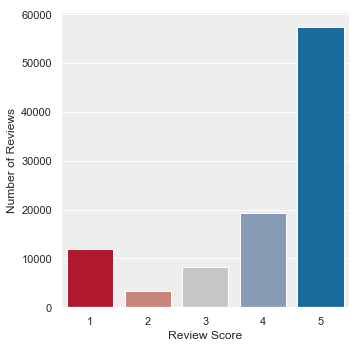

In [6]:
sns.catplot(
    x='review_score',
    kind='count',
    data=reviews,
    palette=REVIEWS_PALETTE
).set(
    xlabel='Review Score',
    ylabel='Number of Reviews',
);

In [7]:
reviews.groupby('order_status')['order_status'].count()

order_status
approved           2
canceled         629
created            5
delivered      97015
invoiced         318
processing       302
shipped         1118
unavailable      611
Name: order_status, dtype: int64

3. Exploring Review Comments #TODO

4. Wrapping up

Model

In [8]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
reviews = reviews[['review_score','review_comment_message']]

reviews.head()

,review_score,review_comment_message
0,4,NaN
1,5,NaN
2,5,NaN
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...


In [10]:
reviews.dropna(inplace=True)

reviews.head()

,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."


In [11]:
len(reviews)

41753

In [12]:
tfidf = TfidfVectorizer(min_df = 3, ngram_range=(1, 1))

features = tfidf.fit_transform(reviews['review_comment_message']).toarray()

labels = reviews['review_score']

features.shape

(41753, 5509)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 0, stratify=labels)

clf = MultinomialNB().fit(X_train, y_train)

In [14]:
print(clf.predict(tfidf.transform(["demorado não entregue"])))

[1]


In [15]:
print(clf.predict(tfidf.transform(["entregue"])))

[5]


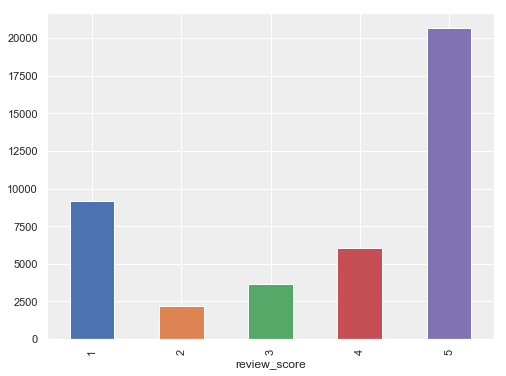

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
reviews.groupby('review_score')['review_score'].count().plot.bar(ylim=0)
plt.show()

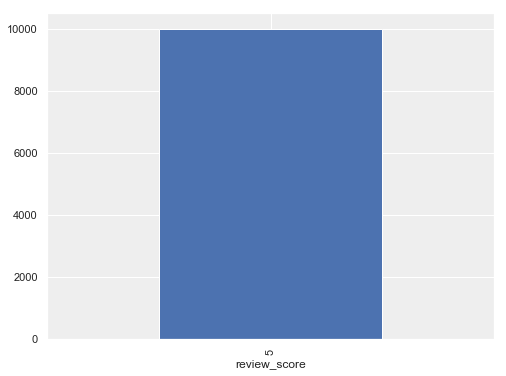

In [17]:
#max_size = labels.value_counts().max()
max_size = 10000

df_5 = reviews.groupby('review_score').get_group(5).sample(max_size, replace=True)

fig = plt.figure(figsize=(8,6))
df_5.groupby('review_score').review_score.count().plot.bar(ylim=0)
plt.show()

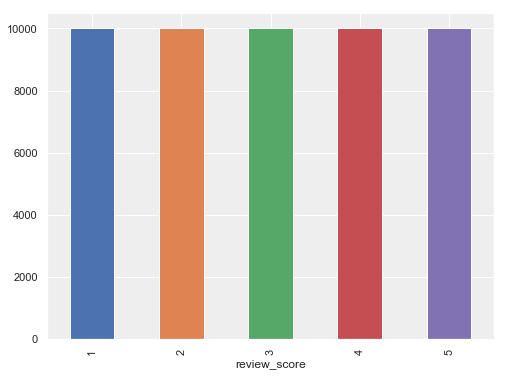

In [18]:
df_5 = reviews.groupby('review_score').get_group(5).sample(max_size, replace=True)

reviews.drop(reviews.groupby('review_score').get_group(5).index, inplace=True)

lst = [reviews,df_5]

for class_index, group in reviews.groupby('review_score'):
    lst.append(group.sample(max_size-len(group), replace=True))
df_balanced = pd.concat(lst)

fig = plt.figure(figsize=(8,6))
df_balanced.groupby('review_score').review_score.count().plot.bar(ylim=0)
plt.show()

In [19]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1, 1))

features = tfidf.fit_transform(df_balanced['review_comment_message']).toarray()

labels = df_balanced['review_score']

features.shape

(50000, 3225)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 0, stratify=labels)

clf = MultinomialNB().fit(X_train, y_train)

In [21]:
print(clf.predict(tfidf.transform(["entregue"])))

[5]


In [22]:
print(clf.predict(tfidf.transform(["demorado não entregue"])))

[3]


In [23]:
print(clf.predict(tfidf.transform(["não entregue"])))

[1]


In [24]:
print(clf.predict(tfidf.transform(["demorado"])))

[3]


In [25]:
print(clf.predict(tfidf.transform(["demorado mas entregue"])))

[3]


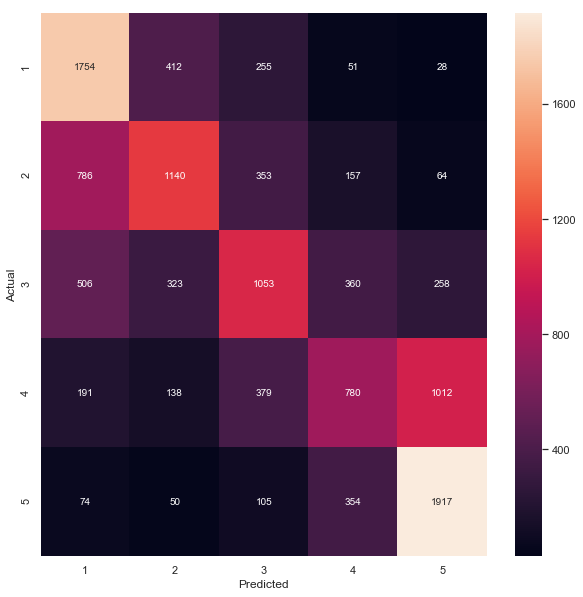

In [26]:
y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

In [28]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.53      0.70      0.60      2500
           2       0.55      0.46      0.50      2500
           3       0.49      0.42      0.45      2500
           4       0.46      0.31      0.37      2500
           5       0.58      0.77      0.66      2500

   micro avg       0.53      0.53      0.53     12500
   macro avg       0.52      0.53      0.52     12500
weighted avg       0.52      0.53      0.52     12500

